In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab/diffusion/generative-inverse-heat-dissipation
#%cd /content/drive/MyDrive/diffusion/generative-inverse-heat-dissipation

/content/drive/MyDrive/Colab/diffusion/generative-inverse-heat-dissipation


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision.utils import make_grid
from torchvision.io import read_image
from torchvision import transforms
from torch.fft import fft2,ifft2
from model_code.torch_dct import dct_2d,idct_2d


In [4]:
def min_max_norm_batch_0_1(x:torch.tensor):
    """Returns the min-max normalization of x across batch."""
    return (x - x.min()) / (x.max() - x.min())


In [5]:
def min_max_norm_batch_minus1_1(x:torch.tensor):
    """Returns the min-max normalization of x across batch."""
    return (2*x - x.min() - x.max()) / (x.max() - x.min())


In [6]:
def min_max_norm_image(x:torch.tensor):
    """
    Returns the min-max normalization per image in the
    batch instead of over the entire batch of images.
    """
    b = x.shape[0]
    x_min = x.view(b, -1).min(dim=1).values[:, None, None, None]
    x_max = x.view(b, -1).max(dim=1).values[:, None, None, None]
    return (x - x_min) / (x_max - x_min)

In [7]:
def show_batch_imgs(imgs,nrow=4):
    img_grid = make_grid(imgs,nrow=nrow,padding=0)
    img_tmp = torchvision.transforms.ToPILImage()(img_grid)
    display(img_tmp) # img_tmp.show()
    #fig=plt.figure()
    #fig.set_size_inches(1,8)
    #plt.imshow(img_grid.permute(1,2,0))
    #plt.axis('off')
    #plt.show()
    return

In [ ]:
for file in random.sample(files, min(1, len(files)))


In [23]:
import os
import random

#from skimage import io
#import cv2

path = './selected_images'

IMG_SIZE=128 # 32
imgs_n = 8
files = os.listdir(path)
files.sort()

# files = [files[x] for x in [1,2,3,5,15,17,48,56]]

imgs = []
for i,img in enumerate(files):
    img_path=os.path.join(path,img)
    img_arr=read_image(img_path)
    imgs.append(img_arr)
    if i== imgs_n-1:
        break
imgs = torch.from_numpy(np.array(imgs))/255  # normalize between 0-1
#imgs = min_max_norm_batch_0_1(imgs)
transform = transforms.Resize(size=(128,128),antialias=False)
imgs = transform(imgs)
#imgs[:] = imgs[6,:,:,:]  # select index of images in dataset، for all imgs pls ignore this line
print(imgs.shape)
show_batch_imgs(imgs)

SyntaxError: expected ':' (<ipython-input-23-0c85804ea0c0>, line 14)

torch.Size([64, 3, 64, 64])


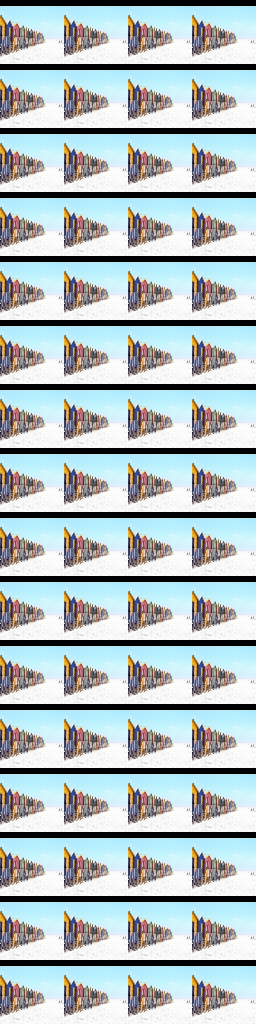

In [10]:
img_path =  './data/image_1.jpg'
# img_path =  './Linnaeus/Linnaeus 5 256X256/train/other/46_256.jpg'
img_arr=read_image(img_path)

img_arr = torch.from_numpy(np.array(img_arr))/255  # normalize between 0-1
#imgs = min_max_norm_batch_0_1(imgs)
transform = transforms.Resize(size=(64,64),antialias=False)
img_arr = transform(img_arr)
imgs = torch.zeros((64,*img_arr.shape))
imgs[:] = img_arr[:,:,:]  # select index of images in dataset، for all imgs pls ignore this line
print(imgs.shape)
show_batch_imgs(imgs)

In [11]:
class FFTBlur(nn.Module):
    def __init__(self,blur_sigmas, image_size, device):
        super(FFTBlur,self).__init__()

        self.image_width = image_size
        self.image_height = image_size
        self.device = device
        self.H_bar = self.create_kernel(self.image_width,self.image_height)
        self.H_tilde = self.matrix_flip(self.H_bar)
        self.fft2_H_tilde = fft2(self.H_tilde)
        #self.fft2_H_tilde_n = torch.zeros((batch_size,channel,image_width,image_height),dtype=torch.complex64)
        #self.fft2_H_tilde_n[:,:] = self.fft2_H_tilde

    def destination_center(self,width,height):
        (cw1,ch1) = (width//2 +1 , height//2 +1) # center of destination
        return (cw1,ch1)

    def source_center(self,width,height):
        (cw1,ch1) = self.destination_center(width,height)
        (cw2,ch2) = (width-cw1 , height-ch1) # center of source
        return (cw2,ch2)

    def create_kernel(self,width,height):
        H =1/8*torch.tensor([[0,1,0],
                            [1,4,1],
                            [0,1,0]]).to(self.device)

        # H =1/1*np.array([[1,1,1],
        #                 [1,1,1],
        #                 [1,1,1]]).to(self.device)
        (cw2,ch2) = self.source_center(width,height)
        H_bar = torch.zeros((width,height)).to(self.device)
        H_bar[cw2-1:cw2+2,ch2-1:ch2+2] = H
        return H_bar

    def matrix_flip(self,H_bar):
        (w,h) = H_bar.shape
        (cw1,ch1) = self.destination_center(w,h)
        (cw2,ch2) = self.source_center(w,h)

        H_tilde = torch.zeros_like(H_bar)
        H_tilde[0:cw1,0:ch1]= H_bar[cw2:w,ch2:h]
        H_tilde[cw1:w,0:ch1]= H_bar[0:cw2,ch2:h]
        H_tilde[0:cw1,ch1:h]= H_bar[cw2:w,0:ch2]
        H_tilde[cw1:w,ch1:h]= H_bar[0:cw2,0:ch2]
        return H_tilde

    def forward(self,x,fwd_steps):
        #imgs_tmp = min_max_norm_batch_0_1(imgs)
        t = fwd_steps[:,None,None,None]
        fft2_H_tilde_t = self.fft2_H_tilde[None,None,:,:]**t
        return ifft2(fft2_H_tilde_t*fft2(x)).real#.to(torch.uint8)



In [13]:
fftblur = FFTBlur(0,imgs.shape[2],'cpu')

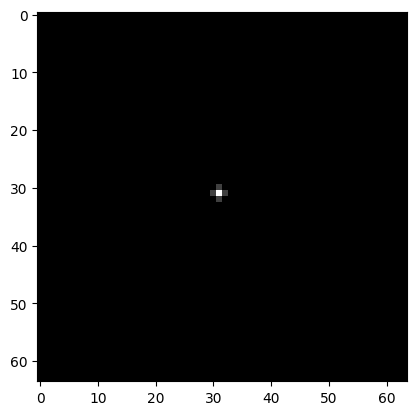

In [ ]:
plt.imshow(fftblur.H_bar.real,cmap='gray')
plt.show()

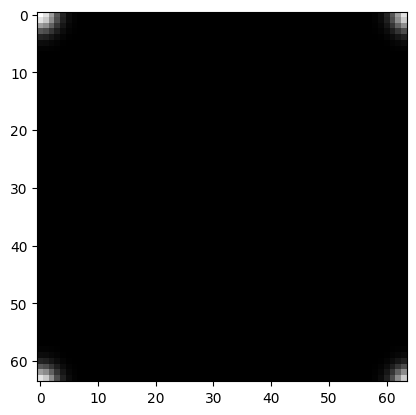

In [ ]:
plt.imshow(((fftblur.fft2_H_tilde)**100).real,cmap='gray')
plt.show()

tensor([9.9897e-05, 4.4843e+00, 1.6673e+01, 7.0544e+01, 1.3987e+02, 2.7491e+02,
        7.5177e+02, 2.0480e+03])


RuntimeError: The size of tensor a (8) must match the size of tensor b (64) at non-singleton dimension 0

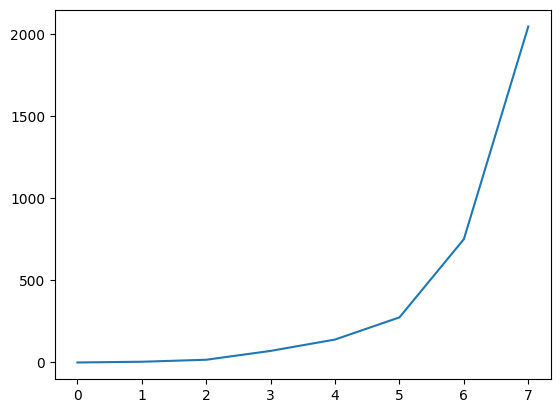

In [14]:
steps = torch.tensor([0,30,60,100,120,140,170,200])
L,H,b = 0.0001 , imgs.shape[2]*32 , 30
a = (H-L) / (torch.exp(torch.tensor(200/b))-1)
c = a - L
t= a * torch.exp(steps/b) - c
print(t)
plt.plot(t)
blur_imgs = fftblur(imgs,t)
print(torch.min(blur_imgs),torch.max(blur_imgs))
#blur_imgs = min_max_norm_batch_0_1(blur_imgs)
show_batch_imgs(blur_imgs,len(steps))

In [15]:
# https://github.com/AaltoML/generative-inverse-heat-dissipation/blob/main/model_code/utils.py
from model_code import utils as mutils
from model_code.utils import DCTBlur

K = 200
blur_sigma_max = 24
blur_sigma_min = 0.5
blur_schedule = np.exp(np.linspace(np.log(blur_sigma_min),
                                            np.log(blur_sigma_max), K))
blur_schedule = np.array(
    [0] + list(blur_schedule))  # Add the k=0 timestep
forward_process_module = DCTBlur(blur_schedule, imgs.shape[2], 'cpu')

bimg = forward_process_module(imgs,steps)
show_batch_imgs(bimg,8)

RuntimeError: The size of tensor a (64) must match the size of tensor b (8) at non-singleton dimension 0

(128, 128)
torch.Size([1, 1, 128, 128])


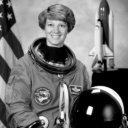

In [ ]:
from skimage import data,color
from skimage.transform import resize
imgnp = data.astronaut()
imgnp = color.rgb2gray(imgnp)
imgnp = resize(imgnp, (128,128),anti_aliasing=True)
print(imgnp.shape)
imgsth=torch.tensor(imgnp[None,None,:,:])
print(imgsth.shape)
show_batch_imgs(imgsth,1)

tensor(-0.0023, dtype=torch.float64) tensor(0.9970, dtype=torch.float64)


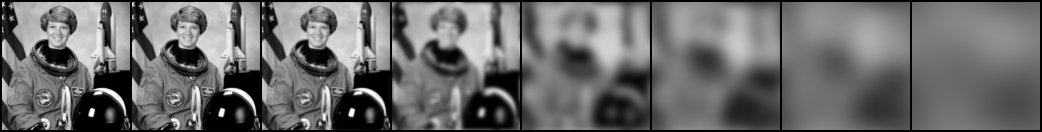

In [ ]:
steps = torch.tensor([0,10,20,50,70,80,90,100])
L,H,b = 0.000001 , 2000 , 10
a = (H-L) / (torch.exp(torch.tensor(100/b))-1)
c = a - L
t= a*torch.exp(steps/b)-c
blur_imgs = fftblur(imgsth,t)
print(torch.min(blur_imgs),torch.max(blur_imgs))
#blur_imgs = min_max_norm_batch_0_1(blur_imgs)
show_batch_imgs(blur_imgs,8)

In [ ]:
# https://arxiv.org/pdf/2206.13397
# page 18 - Algorithm 3 Python code for calculating the forward process
import numpy as np
from scipy.fftpack import dct, idct
def heat_eq_forward(u, t):
    # Assuming the image u is an (KxK) numpy array
    K = u.shape[-1]
    freqs = np.pi*np.linspace(0,K-1,K)/K
    frequencies_squared = freqs[:,None]**2 + freqs[None,:]**2
    u_proj = dct(u, axis=0, norm='ortho')
    u_proj = dct(u_proj, axis=1, norm='ortho')
    u_proj = np.exp( - frequencies_squared * t) * u_proj
    u_reconstucted = idct(u_proj, axis=0, norm='ortho')
    u_reconstucted = idct(u_reconstucted, axis=1, norm='ortho')
    return u_reconstucted

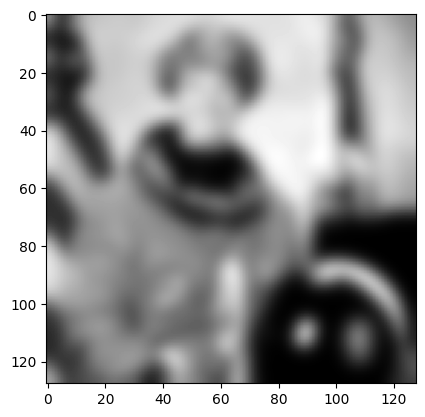

In [ ]:
img_blure = heat_eq_forward(imgnp,4)
plt.imshow(img_blure,cmap ='gray')
plt.show()

31

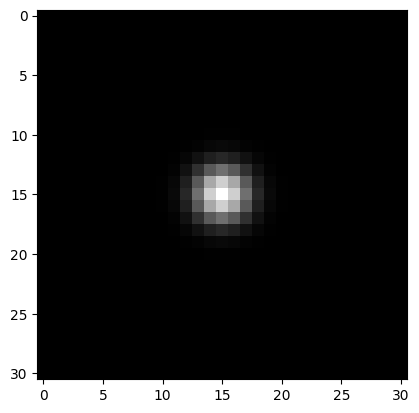

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_gaussian_kernel(w,h,sigma):
    kernel = np.zeros((w,h))
    for xi in range(w):
        for yi in range(h):
            x = (xi-w//2) / w
            y = (yi-h//2) / h
            kernel[xi,yi] = np.exp(-(x**2+y**2)/(2*sigma**2))
    return 1/np.sqrt(2*np.pi*sigma**2)*kernel

kernel = create_gaussian_kernel(w=31,h=31,sigma=0.05)

plt.imshow(kernel,cmap = 'gray')
plt.show()

tensor(-0.0414, dtype=torch.float64) tensor(8.1491, dtype=torch.float64)


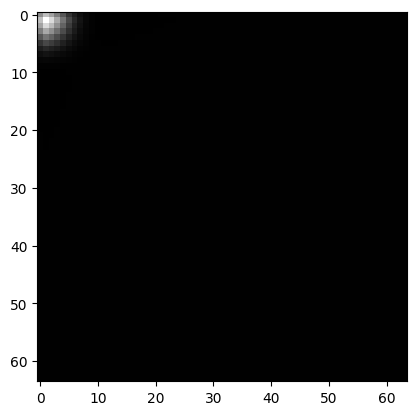

In [ ]:
kernel_dct = dct_2d(torch.from_numpy(kernel), norm='ortho')
#kernel_dct = min_max_norm_batch_0_1(kernel_dct)
print(torch.min(kernel_dct),torch.max(kernel_dct))
plt.imshow(kernel_dct,cmap = 'gray')
plt.show()

tensor(5.1488e-06) tensor(1.)


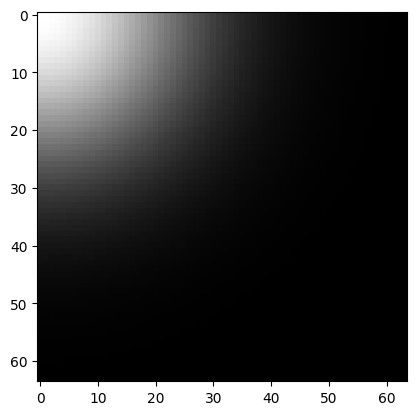

In [ ]:
img_size = 64
alpha =2*np.pi/(img_size*img_size)
#freqs2 = np.pi*torch.linspace(0, img_size-1,img_size)/img_size
freqs2 = torch.linspace(0, img_size-1,img_size)
frequencies_squared2 = freqs2[:, None]**2 + freqs2[None, :]**2
exp_freqs_squared2 = torch.exp(- alpha* frequencies_squared2)
print(torch.min(exp_freqs_squared2),torch.max(exp_freqs_squared2))

plt.imshow(exp_freqs_squared2,cmap = 'gray')
plt.show()

tensor(-0.0002) tensor(1.)


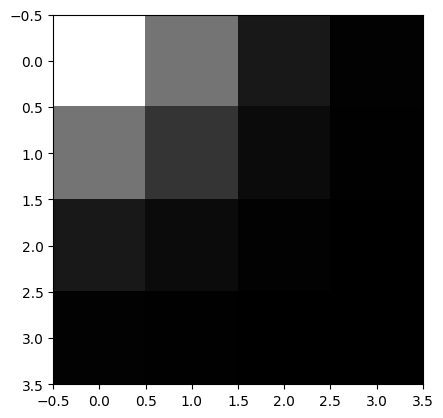

In [ ]:
exp_freqs_squared_idct2=idct_2d(exp_freqs_squared2)
exp_freqs_squared_idct2_normal = exp_freqs_squared_idct2/torch.max(exp_freqs_squared_idct2)
print(torch.min(exp_freqs_squared_idct2_normal),torch.max(exp_freqs_squared_idct2_normal))
plt.imshow((exp_freqs_squared_idct2_normal[:4,:4]),cmap = 'gray')
plt.show()

In [ ]:
exp_freqs_squared_idct2_normal[:4,:4]

tensor([[1.0000, 0.9988, 0.9964, 0.9928],
        [0.9988, 0.9976, 0.9952, 0.9916],
        [0.9964, 0.9952, 0.9928, 0.9892],
        [0.9928, 0.9916, 0.9892, 0.9857]])

In [ ]:
torch.log(exp_freqs_squared_idct2_normal[:4,:4])

tensor([[ 0.0000, -0.0012, -0.0036, -0.0072],
        [-0.0012, -0.0024, -0.0048, -0.0084],
        [-0.0036, -0.0048, -0.0072, -0.0108],
        [-0.0072, -0.0084, -0.0108, -0.0144]])

0.25
tensor(0.) tensor(1.)


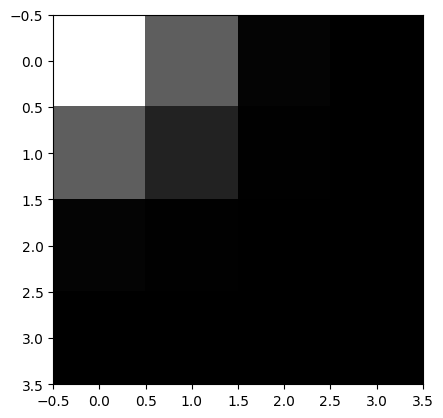

In [ ]:
img_size = 64
beta =1/1#/np.sqrt(np.pi)#0.036* img_size / (np.pi)
print(alpha)
freqs1 =torch.linspace(0, img_size-1,img_size)
frequencies_squared1 = freqs1[:, None]**2 + freqs1[None, :]**2
exp_freqs_squared1 = torch.exp(- beta *frequencies_squared1)
print(torch.min(exp_freqs_squared1),torch.max(exp_freqs_squared1))

plt.imshow(exp_freqs_squared1[:4,:4],cmap = 'gray')
plt.show()

In [ ]:
exp_freqs_squared1[:6,:6]-exp_freqs_squared_idct2_normal[:6,:6]

tensor([[ 0.0000,  0.0087,  0.0104,  0.0057, -0.0036, -0.0154],
        [ 0.0087,  0.0171,  0.0184,  0.0132,  0.0033, -0.0091],
        [ 0.0104,  0.0184,  0.0194,  0.0144,  0.0048, -0.0072],
        [ 0.0057,  0.0132,  0.0144,  0.0100,  0.0014, -0.0094],
        [-0.0036,  0.0033,  0.0048,  0.0014, -0.0056, -0.0144],
        [-0.0154, -0.0091, -0.0072, -0.0094, -0.0144, -0.0210]])

In [ ]:
torch.log(exp_freqs_squared1[:6,:6])/torch.log(exp_freqs_squared_idct2_normal[:6,:6])

tensor([[   nan, 1.2727, 1.6990, 1.9001, 2.1614,    nan],
        [1.2727, 1.2727, 1.5924, 1.8108, 2.0761,    nan],
        [1.6990, 1.5924, 1.6990, 1.8333, 2.0498,    nan],
        [1.9001, 1.8108, 1.8333, 1.9001, 2.0595,    nan],
        [2.1614, 2.0761, 2.0498, 2.0595, 2.1612,    nan],
        [   nan,    nan,    nan,    nan,    nan, 2.9475]])

In [ ]:
img = initial_sample_dict['dctblur'][5][42].permute(1,2,0)[:,:,0]

import matplotlib.pyplot as plt
import numpy as np

# Generate data for the plot
x = np.linspace(0, 1, 32)
y = np.linspace(0, 1, 32)
r = np.random.RandomState(42)
z = img
# Generate the plot
fig, ax = plt.subplots()
cmap = plt.contourf(x, y, z,cmap='coolwarm')
fig.colorbar(cmap)
plt.title('DCTBlur')
plt.show(fig)

(128, 128)
torch.Size([128, 128])


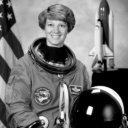

In [ ]:
from skimage import data,color
from skimage.transform import resize
imgnp = data.astronaut()
imgnp = color.rgb2gray(imgnp)
imgnp = resize(imgnp, (128,128),anti_aliasing=True)
print(imgnp.shape)
imgsth=torch.tensor(imgnp)
print(imgsth.shape)
show_batch_imgs(imgsth,1)

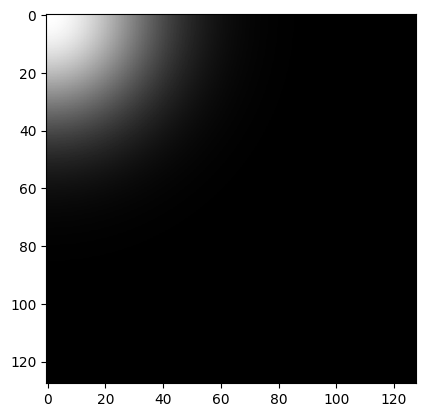

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_gaussian_kernel(w,h,sigma):
    kernel = np.zeros((w,h))
    for xi in range(w):
        for yi in range(h):
            x = xi/w #-1/2
            y = yi/h #-1/2
            kernel[xi,yi] = np.exp(-(x**2+y**2)/(2*sigma**2))
    return 1/np.sqrt(2*np.pi*sigma**2)*kernel

kernel = create_gaussian_kernel(w=128,h=128,sigma=0.2)

plt.imshow(kernel,cmap = 'gray')
plt.show()

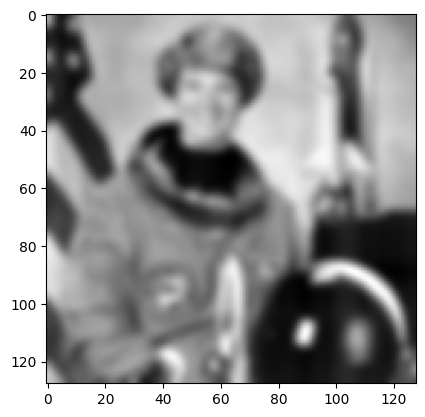

In [ ]:
kernel = torch.from_numpy(create_gaussian_kernel(w=128,h=128,sigma=0.01))
t=1
img_blur=idct_2d((dct_2d(kernel, norm='ortho')**t)*dct_2d(imgsth, norm='ortho'), norm='ortho')
plt.imshow(img_blur,cmap = 'gray')
plt.show()

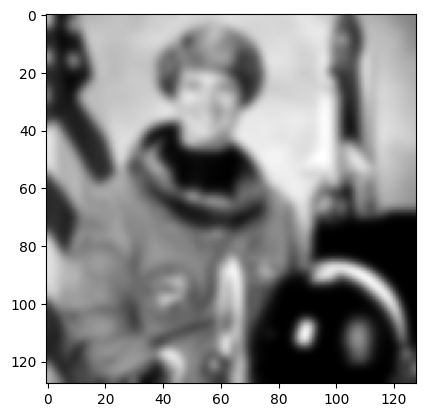

In [ ]:
kernel = torch.from_numpy(create_gaussian_kernel(w=128,h=128,sigma=0.2))
t=1
img_blur=idct_2d((kernel**t)*dct_2d(imgsth, norm='ortho'), norm='ortho')
plt.imshow(img_blur,cmap = 'gray')
plt.show()

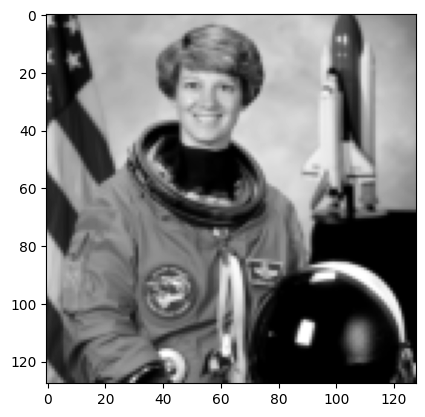

In [ ]:
img_new = idct_2d(dct_2d(img_blur, norm='ortho')/(kernel**t), norm='ortho')
plt.imshow(img_new,cmap = 'gray')
plt.show()

In [ ]:
img_new

tensor([[0.6158, 0.6332, 0.4706,  ..., 0.4798, 0.4701, 0.4648],
        [0.8644, 0.7443, 0.3133,  ..., 0.4752, 0.4682, 0.4644],
        [0.8638, 0.7358, 0.3222,  ..., 0.4774, 0.4697, 0.4643],
        ...,
        [0.6804, 0.6963, 0.6089,  ..., 0.1467, 0.1898, 0.3862],
        [0.6806, 0.6415, 0.5363,  ..., 0.2044, 0.2409, 0.1206],
        [0.6619, 0.5731, 0.4970,  ..., 0.1803, 0.1892, 0.0381]],
       dtype=torch.float64)

In [ ]:
imgsth

tensor([[0.6158, 0.6332, 0.4706,  ..., 0.4798, 0.4701, 0.4648],
        [0.8644, 0.7443, 0.3133,  ..., 0.4752, 0.4682, 0.4644],
        [0.8638, 0.7358, 0.3222,  ..., 0.4774, 0.4697, 0.4643],
        ...,
        [0.6804, 0.6963, 0.6089,  ..., 0.1467, 0.1898, 0.3862],
        [0.6806, 0.6415, 0.5363,  ..., 0.2044, 0.2409, 0.1206],
        [0.6619, 0.5731, 0.4970,  ..., 0.1803, 0.1892, 0.0381]],
       dtype=torch.float64)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_gaussian_kernel(w,h,sigma):
    kernel = np.zeros((w,h))
    for xi in range(w):
        for yi in range(h):
            x = xi/(w-1) -1/2
            y = yi/(h-1) -1/2
            kernel[xi,yi] = np.exp(-(x**2+y**2)/(2*sigma**2))
    return 1/np.sqrt(2*np.pi*sigma**2)*kernel

fftblur = FFTBlur(0,128,'cpu')

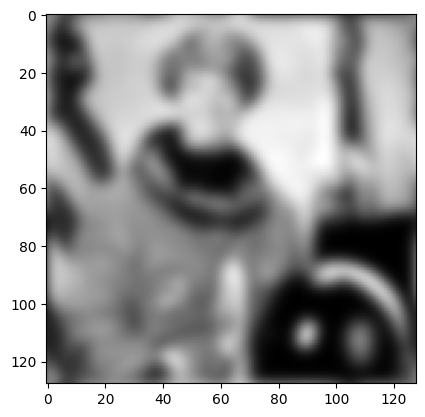

In [ ]:
t=1
kernel = torch.from_numpy(create_gaussian_kernel(w=128,h=128,sigma=0.02))
H_tilde = fftblur.matrix_flip(kernel) #fftblur.H_tilde
blur_imgs = ifft2( (fft2(H_tilde)**t) * fft2(imgsth) ).real
plt.imshow(blur_imgs,cmap = 'gray')
plt.show()

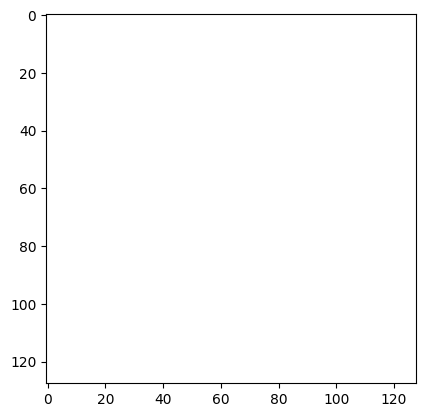

In [ ]:
t=1
kernel = torch.from_numpy(create_gaussian_kernel(w=128,h=128,sigma=0.02))
H_tilde = fftblur.matrix_flip(kernel) #fftblur.H_tilde
blur_imgs = ifft2( (fft2(H_tilde)**t) * fft2(imgsth) ).real

img_new = ifft2 ( fft2(blur_imgs) / (fft2(H_tilde)**t) ).real
plt.imshow(img_new,cmap = 'gray')
plt.show()